# Linear Regression Modeling

In [26]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
from collections import defaultdict
import dateutil.parser
from pprint import pprint
import pandas
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from copy import deepcopy
import seaborn as sns
import urllib2, sys
import string
import gevent.monkey
gevent.monkey.patch_socket()
from gevent.pool import Pool
from sklearn.cross_validation import train_test_split
from patsy import dmatrices, dmatrix
import statsmodels.api as sm
from sklearn.metrics import r2_score
%matplotlib inline

## Set up the data for modeling

Open up CSV into pandas dataframe

In [112]:
df = pd.read_csv('csv/no_nc.csv',encoding='utf-8')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

dist  dom_tot_gross   genre                       title  movieid  \
0  Orion Pictures     90944400.0  Comedy     Dirty Rotten Scoundrels        1   
1             Fox    252358600.0  Action                       Speed        2   
2       Paramount     48884600.0  Comedy          The Out-of-Towners        3   
3       Universal     39263600.0   Drama  Captain Corelli's Mandolin        4   
4      DreamWorks     55006600.0  Comedy               Head of State        7   

   num_theaters    open_rev      budget rating     release  runtime  \
0        1515.0   8129500.0         NaN     PG  1988-12-16    110.0   
1        2169.0  30088300.0  30000000.0      R  1994-06-10    116.0   
2        2128.0  14084800.0  75000000.0  PG-13  1999-04-02     90.0   
3        1612.0  11081500.0  57000000.0      R  2001-08-17    129.0   
4        2256.0  19482600.0         NaN  PG-13  2003-03-28     95.0   

   time_theaters  month  meta_rating    rating_bin  decay rate  
0           56.0   12.0           68  (60.4, 80.2]   -0.252520  
1           70.0    6.0           78  (60.4, 80.2]   -0.202080  
2          105.0    4.0           33  (20.8, 40.6]   -0.181253  
3           63.0    8.0           36  (20.8, 40.6]   -0.298635  
4          112.0    3.0           44  (40.6, 60.4]   -0.123494

Drop any variables not to be used in the final model

In [113]:
df.drop('rating_bin', axis=1, inplace=True)
df.drop('title', axis=1, inplace=True)
df.drop('movieid', axis=1, inplace=True)
df.drop('dist', axis=1, inplace=True)
df.drop('release', axis=1, inplace=True)

Get rid of NC-17 movies

In [114]:
df = df[df['rating'] != 'NC-17']

Create binary columns for the categorical variables

In [115]:
def add_binary(df, column_list, category):
    """
    Given a DataFrame, a name of a column, and a list of 
    the items in that column, create binary variables.
    """
    for c in column_list:
        df[c] = np.where(df[category] == c, 1, 0)
    return df

In [116]:
df = add_binary(df, df['rating'].unique(), 'rating')
df = add_binary(df, df['month'].unique(), 'month')
df = add_binary(df, df['genre'].unique(), 'genre')
df.head()

dom_tot_gross   genre  num_theaters    open_rev      budget rating  \
0     90944400.0  Comedy        1515.0   8129500.0         NaN     PG   
1    252358600.0  Action        2169.0  30088300.0  30000000.0      R   
2     48884600.0  Comedy        2128.0  14084800.0  75000000.0  PG-13   
3     39263600.0   Drama        1612.0  11081500.0  57000000.0      R   
4     55006600.0  Comedy        2256.0  19482600.0         NaN  PG-13   

   runtime  time_theaters  month  meta_rating     ...       10.0  1.0  Comedy  \
0    110.0           56.0   12.0           68     ...          0    0       1   
1    116.0           70.0    6.0           78     ...          0    0       0   
2     90.0          105.0    4.0           33     ...          0    0       1   
3    129.0           63.0    8.0           36     ...          0    0       0   
4     95.0          112.0    3.0           44     ...          0    0       1   

   Action  Drama  Horror / Thriller  Family  Animation  Sci-Fi  Documentary  
0       0      0                  0       0          0       0            0  
1       1      0                  0       0          0       0            0  
2       0      0                  0       0          0       0            0  
3       0      1                  0       0          0       0            0  
4       0      0                  0       0          0       0            0  

[5 rows x 36 columns]

Drop any movies with nulls

In [117]:
df = df.dropna(axis=0, how='any')
df.head()

dom_tot_gross   genre  num_theaters    open_rev      budget rating  \
1     252358600.0  Action        2169.0  30088300.0  30000000.0      R   
2      48884600.0  Comedy        2128.0  14084800.0  75000000.0  PG-13   
3      39263600.0   Drama        1612.0  11081500.0  57000000.0      R   
10    108847100.0  Family        3122.0  35028600.0  90000000.0     PG   
12     90346600.0  Action        2641.0  29077200.0  25000000.0      R   

    runtime  time_theaters  month  meta_rating     ...       10.0  1.0  \
1     116.0           70.0    6.0           78     ...          0    0   
2      90.0          105.0    4.0           33     ...          0    0   
3     129.0           63.0    8.0           36     ...          0    0   
10     99.0          142.0   11.0           34     ...          0    0   
12    115.0           89.0    3.0           52     ...          0    0   

    Comedy  Action  Drama  Horror / Thriller  Family  Animation  Sci-Fi  \
1        0       1      0                  0       0          0       0   
2        1       0      0                  0       0          0       0   
3        0       0      1                  0       0          0       0   
10       0       0      0                  0       1          0       0   
12       0       1      0                  0       0          0       0   

    Documentary  
1             0  
2             0  
3             0  
10            0  
12            0  

[5 rows x 36 columns]

Rescale the features for better interpretability

In [118]:
df['log(budget)'] = np.log(df.budget)
df['log(meta_rating)'] = np.log(df.meta_rating)
df.head()

dom_tot_gross   genre  num_theaters    open_rev      budget rating  \
1     252358600.0  Action        2169.0  30088300.0  30000000.0      R   
2      48884600.0  Comedy        2128.0  14084800.0  75000000.0  PG-13   
3      39263600.0   Drama        1612.0  11081500.0  57000000.0      R   
10    108847100.0  Family        3122.0  35028600.0  90000000.0     PG   
12     90346600.0  Action        2641.0  29077200.0  25000000.0      R   

    runtime  time_theaters  month  meta_rating        ...         Comedy  \
1     116.0           70.0    6.0           78        ...              0   
2      90.0          105.0    4.0           33        ...              1   
3     129.0           63.0    8.0           36        ...              0   
10     99.0          142.0   11.0           34        ...              0   
12    115.0           89.0    3.0           52        ...              0   

    Action  Drama  Horror / Thriller  Family  Animation  Sci-Fi  Documentary  \
1        1      0                  0       0          0       0            0   
2        0      0                  0       0          0       0            0   
3        0      1                  0       0          0       0            0   
10       0      0                  0       1          0       0            0   
12       1      0                  0       0          0       0            0   

    log(budget)  log(meta_rating)  
1     17.216708          4.356709  
2     18.132999          3.496508  
3     17.858562          3.583519  
10    18.315320          3.526361  
12    17.034386          3.951244  

[5 rows x 38 columns]

## Run Logistic Regression
The features were chosen by doing a manual grid search of all combinations and choosing the set of features with the highest R-squared.

Define X and add intercept

In [119]:
X = df.iloc[:,11:]
X['intercept'] = np.ones(X.shape[0])
X.head()

PG  R  PG-13  G  Unrated  12.0  6.0  4.0  8.0  3.0    ...      Action  \
1    0  1      0  0        0     0    1    0    0    0    ...           1   
2    0  0      1  0        0     0    0    1    0    0    ...           0   
3    0  1      0  0        0     0    0    0    1    0    ...           0   
10   1  0      0  0        0     0    0    0    0    0    ...           0   
12   0  1      0  0        0     0    0    0    0    1    ...           1   

    Drama  Horror / Thriller  Family  Animation  Sci-Fi  Documentary  \
1       0                  0       0          0       0            0   
2       0                  0       0          0       0            0   
3       1                  0       0          0       0            0   
10      0                  0       1          0       0            0   
12      0                  0       0          0       0            0   

    log(budget)  log(meta_rating)  intercept  
1     17.216708          4.356709        1.0  
2     18.132999          3.496508        1.0  
3     17.858562          3.583519        1.0  
10    18.315320          3.526361        1.0  
12    17.034386          3.951244        1.0  

[5 rows x 28 columns]

Define y

In [120]:
y = df['decay rate']

Split into training and testing set

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Train and fit an OLS model and look at the results.<br/><br/>
Though the R-squared is somewhat low, the features are all mostly significant, which we can see by looking at the p-values less than 0.05, or the features with a confidence interval that does not contain 0. We will look at a more in-depth analysis of the beta coefficients in a moment.

In [122]:
model = sm.OLS(y_train, X_train)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             decay rate   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     8.300
Date:                Sun, 17 Jul 2016   Prob (F-statistic):           9.92e-26
Time:                        16:18:07   Log-Likelihood:                 862.61
No. Observations:                1059   AIC:                            -1677.
Df Residuals:                    1035   BIC:                            -1558.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
PG                   -0.0734      0.017     -4.389      0.000        -0.106    -0.041
R                    -0.1565      0.017     -9.080      0.000        -0.190    -0.123
PG-13                -0.1174      0.018     -6.677      0.000        -0.152    -0.083
G                    -0.0583      0.024     -2.458      0.014        -0.105    -0.012
Unrated            1.258e-16   2.14e-17      5.889      0.000      8.39e-17  1.68e-16
12.0                 -0.0378      0.012     -3.033      0.002        -0.062    -0.013
6.0                  -0.0347      0.012     -2.808      0.005        -0.059    -0.010
4.0                   0.0017      0.013      0.130      0.897        -0.023     0.027
8.0                  -0.0435      0.011     -3.936      0.000        -0.065    -0.022
3.0                  -0.0154      0.012     -1.291      0.197        -0.039     0.008
11.0                 -0.0573      0.012     -4.651      0.000        -0.082    -0.033
5.0                  -0.0209      0.013     -1.557      0.120        -0.047     0.005
2.0                  -0.0262      0.012     -2.129      0.034        -0.050    -0.002
9.0                  -0.0260      0.012     -2.100      0.036        -0.050    -0.002
7.0                  -0.0508      0.012     -4.133      0.000        -0.075    -0.027
10.0                 -0.0593      0.011     -5.249      0.000        -0.081    -0.037
1.0                  -0.0354      0.013     -2.624      0.009        -0.062    -0.009
Comedy               -0.0298      0.012     -2.536      0.011        -0.053    -0.007
Action               -0.0537      0.015     -3.639      0.000        -0.083    -0.025
Drama                -0.0513      0.013     -3.990      0.000        -0.077    -0.026
Horror / Thriller    -0.0589      0.013     -4.392      0.000        -0.085    -0.033
Family               -0.0355      0.017     -2.042      0.041        -0.070    -0.001
Animation            -0.0458      0.019     -2.373      0.018        -0.084    -0.008
Sci-Fi               -0.0421      0.018     -2.397      0.017        -0.077    -0.008
Documentary          -0.0885      0.056     -1.571      0.116        -0.199     0.022
log(budget)           0.0065      0.005      1.442      0.150        -0.002     0.015
log(meta_rating)      0.0653      0.010      6.708      0.000         0.046     0.084
intercept            -0.4056      0.058     -6.951      0.000        -0.520    -0.291
==============================================================================
Omnibus:                      915.753   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            65089.272
Skew:                          -3.541   Prob(JB):                         0.00
Kurtosis:                      40.749   Cond. No.                     2.66e+16
======================

Find the adjusted R-squared on the test set. Note that the R-squared is able to be negative when looking at a different set of data (testing vs. training).

In [123]:
y_pred = results.predict(X_test)
r2 = r2_score(y_pred, y_test)
print 'This model as an R-squared of %f on the test set.' % r2

This model as an R-squared of -3.641648 on the test set.


In [124]:
adj_r2 = 1 - (1 - r2) * ((len(y_test) - 1) / (len(y_test) - len(X_test.columns) - 1))
print 'This model as an adjusted R-squared of %f on the test set.' % adj_r2

This model as an adjusted R-squared of -3.641648 on the test set.


Look at the residuals

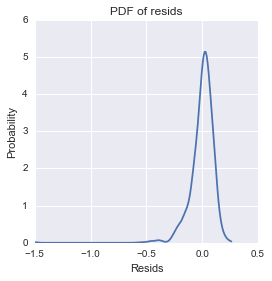

In [125]:
plt.figure(figsize=(4,4))
resid_density = gaussian_kde(results.resid)
xs = np.linspace(results.resid.min(),results.resid.max(),200)
ys = resid_density(xs)
plt.plot(xs, ys)
plt.title('PDF of resids')
plt.ylabel('Probability')
plt.xlabel('Resids')

## Beta Coefficient Analysis
The analysis of the beta coefficients is the crux of this project. I wanted to understand exactly what this model was saying. Below we will look at 5 charts showing the relationship between the 5 features chosen and the decay rate. Then we will look at a beta coefficient chart and see if the results of this model align with what the data shows. 

Below are 5 charts showing the 5 features vs. decay rate:

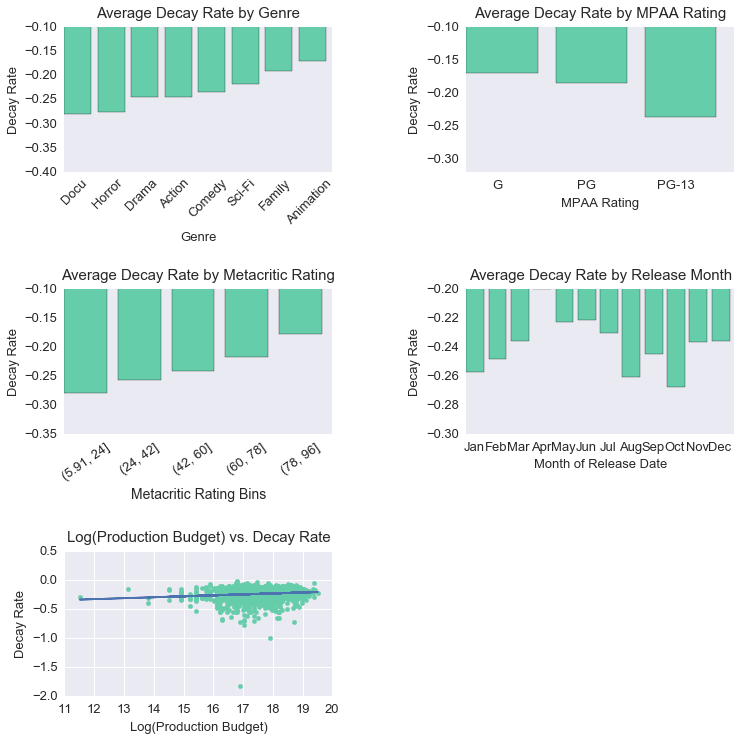

In [126]:
plt.figure(figsize=(12,12))

# Genre
plt.subplot(3,2,1)
genre_avgs = df.groupby(by='genre')['decay rate'].mean().sort_values()
genres = ['Docu','Horror','Drama','Action','Comedy','Sci-Fi','Family','Animation']
xs = np.arange(len(genres))
plt.bar(xs,sorted(genre_avgs), color='mediumaquamarine')
plt.xticks(xs+0.3,genres,fontsize=13,y=0.02,rotation=45)
plt.yticks(fontsize=13)
plt.xlabel('Genre',fontsize=13, y=0.03)
plt.ylabel('Decay Rate',fontsize=13)
plt.title('Average Decay Rate by Genre',fontsize=15, y=1.03)
plt.grid(False)
plt.ylim(-0.4,-0.1)

# Rating
plt.subplot(3,2,2)
ratings_avgs = df.groupby(by='rating')['decay rate'].mean()
ratings = ratings_avgs[:-1].index
xs = np.arange(len(ratings))
plt.bar(xs,ratings_avgs[:-1], color='mediumaquamarine')
plt.xticks(xs + 0.35,ratings, fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('MPAA Rating',fontsize=13)
plt.ylabel('Decay Rate',fontsize=13)
plt.title('Average Decay Rate by MPAA Rating',fontsize=15, y=1.03)
plt.grid(False)
plt.ylim(-0.32,-0.1)

# MetaCritic Score
plt.subplot(3,2,3)
ratings_bin, bins = pd.cut(df['meta_rating'], 5, retbins=True)
df['rating_bin'] = ratings_bin
rating_bin_avgs = df.groupby(by='rating_bin')['decay rate'].mean()
rating_bin_labels = rating_bin_avgs.index
xs = np.arange(len(rating_bin_avgs))
plt.bar(xs,rating_bin_avgs, color='mediumaquamarine')
plt.xticks(xs+0.4,rating_bin_labels, fontsize=13, rotation=35)
plt.yticks(fontsize=13)
plt.xlabel('Metacritic Rating Bins',fontsize=14)
plt.ylabel('Decay Rate',fontsize=13)
plt.title('Average Decay Rate by Metacritic Rating',fontsize=15, y=1.03)
plt.grid(False)
plt.ylim(-0.35,-0.1)

# Release Month
plt.subplot(3,2,4)
month_avgs = df.groupby(by='month')['decay rate'].mean()
month_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
months = np.arange(0,12)
plt.bar(months, month_avgs, color='mediumaquamarine')
plt.xticks(np.arange(len(month_labels))+0.35,month_labels, fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('Decay Rate',fontsize=13)
plt.xlabel('Month of Release Date',fontsize=13)
plt.title('Average Decay Rate by Release Month',fontsize=15, y=1.03)
plt.grid(False)
plt.ylim(-0.3,-0.2)

# Budget
plt.subplot(3,2,5)
xs = df['log(budget)']
ys = df['decay rate']
plt.scatter(xs, ys, color='mediumaquamarine')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Log(Production Budget)',fontsize=13)
plt.ylabel('Decay Rate',fontsize=13)
plt.title('Log(Production Budget) vs. Decay Rate',fontsize=15, y=1.03)
plt.grid(True)
fit = np.polyfit(xs,ys,1)
fit_fn = np.poly1d(fit)
plt.plot(xs,fit_fn(xs))

plt.subplots_adjust(wspace=0.5, hspace=0.8)

Below is a visualization of the beta coefficient chart. The intercept is the starting point and then depending on the genre, MPAA rating, metacritic score, and release month, this number is added to and subtracted from. The betas do seem to make sense. For example, R rated movies have the most negative decay rates and, thus, have the most negative beta. Also, budget and metascore have positive betas and given the charts above, we can see that the higher this number, the less negative the decay rate.  

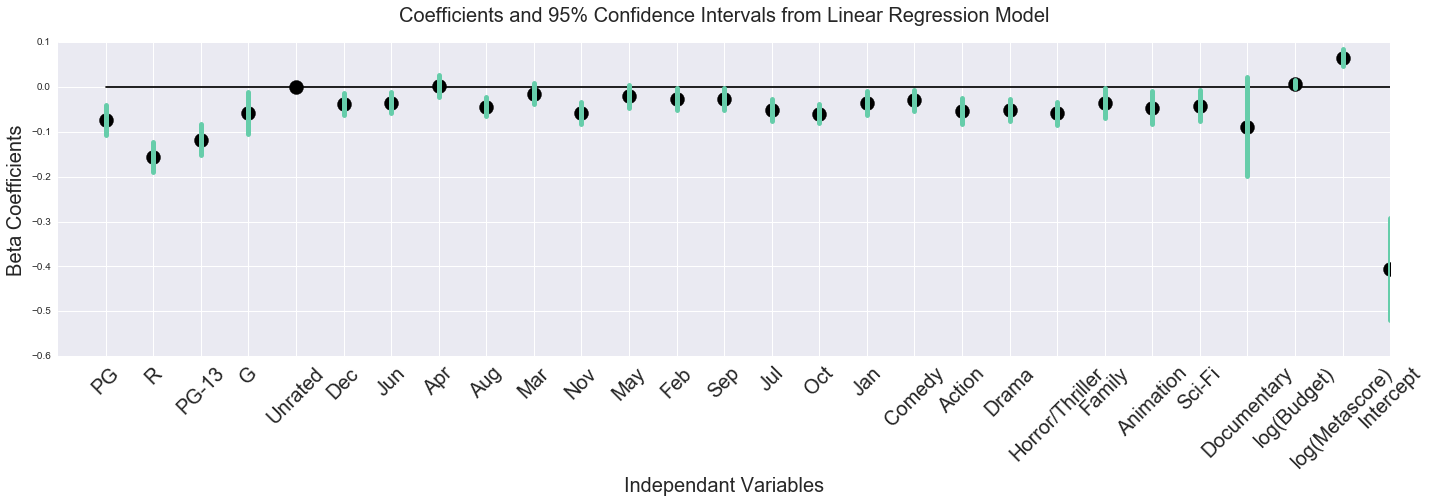

In [127]:
betas = results.params
xs = np.arange(len(betas))

cis = results.conf_int()
plt.figure(figsize=(20,8))
plt.plot(xs, np.zeros(len(xs)),color='black',linewidth=1.7)

itter = cis.iterrows()
x = 0
for interval in itter:
    plt.plot([x,x], [interval[1][0],interval[1][1]], color = 'mediumaquamarine',linewidth=5)
    x += 1

x_labels = ['PG','R','PG-13', 'G', 'Unrated', 'Dec', 'Jun','Apr','Aug','Mar','Nov','May','Feb','Sep','Jul','Oct','Jan',
            'Comedy','Action','Drama','Horror/Thriller','Family','Animation','Sci-Fi','Documentary','log(Budget)',
            'log(Metascore)','Intercept'] 

plt.scatter(xs,betas, s=200, color='black')
plt.xlim(-1,24)
plt.grid(True)
plt.xticks(xs, x_labels, rotation=45, fontsize=20)
plt.title('Coefficients and 95% Confidence Intervals from Linear Regression Model', y=1.05, fontsize=20)
plt.xlabel('Independant Variables',y=0.5, fontsize=20)
plt.ylabel('Beta Coefficients', fontsize=20)
plt.ylim(-0.6,0.1)

ax = plt.gca()
pos1 = ax.get_position()
pos2 = [pos1.x0 - 0.07, pos1.y0 + 0.22,  pos1.width + 0.15, pos1.height - 0.23]
ax.set_position(pos2)
plt.savefig('img/betas.png')